In [1]:
import os
import sys
import math
import re
import time
import random
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import cv2
import skimage
import PIL.Image as pilimg
import glob

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

config = coco.CocoConfig()
#coco.py의 114번 째 라인에서 instance_train2014.json의 위치를 직접 지정해 주었다.
COCO_DIR = "" 

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

Using TensorFlow backend.


In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
weights_path = COCO_MODEL_PATH

model.load_weights(weights_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [4]:
# Build validation dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")

# Must call before using the dataset
dataset.prepare()
print(config.NAME)
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

,train,2014
loading annotations into memory...
Done (t=14.26s)
creating index...
index created!
/train2014
coco
Images: 82081
Classes: ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush

In [5]:
def imwrite(filename, img, params=None):
    try:
        ext = os.path.splitext(filename)[1]
        result, n = cv2.imencode(ext, img, params) 
        if result:
            with open(filename, mode='w+b') as f:
                n.tofile(f)
            return True
        else:
            return False
    except Exception as e:
        print(e)
        return False

In [6]:
def image_resize():
    pass

In [7]:
def bgr2rgb(image):
    wid=image.shape[0]
    hei=image.shape[1]
    
    for w in range(wid):
        for h in range(hei):
            image[w][h][0],image[w][h][2]=image[w][h][2],image[w][h][0]
    return image

In [8]:
def image_merge(image1, image2):
    merged_image=np.zeros((1200, 3200, 3))
    '''
    for h in range(0, 1200):
        for w1 in range(0, 1600):
            merged_image[h][w1] = image1[h][w1]

    for h in range(0, 1200):
        for w2 in range(0, 1600):
            merged_image[h][w2+1600] = image2[h][w2]
    '''
    
    merged_image[:1200, :1600] = image1
    merged_image[:1200, 1600:] = image2
    
    return merged_image

In [9]:
# background_binary_mask = 배경 영역만 까맣게 만들고 '차' 영역은 흰색으로 만든 '이진 마스크'
def background_mask(image,mask):
    width=image.shape[0]
    height=image.shape[1]
    
    background_binary_mask = np.zeros((width, height))
    #revise_mask=np.zeros((width,height))
    
    for w in range(0, width):
        for h in range(0, height):
            if mask[w,h] == False: # 마스크 영역이 아니면 (=배경이면)
                background_binary_mask[w,h]=255.0 # 흰색으로
            else: # 배경이 아니면
                background_binary_mask[w,h]=0.0 # 검은색으로
                
    return background_binary_mask

In [10]:
# paint_only_background_img = background_binary_mask 와 원본이미지를 비교하여, 차는 제외하고 배경만 남은 이미지.
def paint_only_background(image,mask):
    width=image.shape[0]
    height=image.shape[1]
    
    paint_only_background_img = np.zeros((width, height, 3))
    #revise_mask=np.zeros((width,height))
    
    for w in range(0, width):
        for h in range(0, height):
            if mask[w, h] == 255.0: # 배경이면
                paint_only_background_img[w, h, 0] = image[w, h, 0]
                paint_only_background_img[w, h, 1] = image[w, h, 1]
                paint_only_background_img[w, h, 2] = image[w, h, 2]
            elif mask[w, h] == 0.0 : # 배경이 아니면 (=car 영역이면)
                paint_only_background_img[w, h, 0] = 0.0
                paint_only_background_img[w, h, 1] = 0.0
                paint_only_background_img[w, h, 2] = 0.0
    
    return paint_only_background_img

In [11]:
# 캐니 엣지 검출기를 이용하여 "배경의 모서리만 따낸" 이미지를 만든다.
def make_canny_image(only_background_img, mask, num):
    
    width=image.shape[0]
    height=image.shape[1]
 
    # 이유는 모르겠는데 grayscale로 변환이 잘 안돼서 여기서 only_background를 저장했다가 그 다음 줄에서 grayscale 모드로 열었음...
    cv2.imwrite(os.path.join("only_background{}.jpg").format(num), only_background_img)
    # cv2.imwrite(target_directory+"only_background{}.jpg".format(num), only_background_img)
    # grayscale_image = cv2.imread(target_directory+"only_background{}.jpg".format(num), cv2.IMREAD_GRAYSCALE)
    
    # https://stackoverflow.com/questions/55128386/python-opencv-depth-of-image-unsupported-cv-64f/55128619
    only_background_img_uint8 = only_background_img.astype('uint8') * 255 # image.dtype: float -> uint8
    mask = mask.astype('uint8') * 255 # mask.dtype: float64 -> uint8
    grayscale_image = cv2.cvtColor(only_background_img_uint8, cv2.COLOR_BGR2GRAY)
    
    #print(grayscale_image.shape) # (1200, 1600)
    #print(grayscale_image)
    '''
    [[212 212 212 ... 199 198 197]
     [212 212 212 ... 200 199 198]
     [212 212 212 ... 200 200 199]
     ...
     [104 105 106 ... 108 109 110]
     [109 109 109 ... 108 110 111]
     [110 108 105 ... 109 111 112]]
    '''
    
    #cv2.imwrite(os.path.join("rgb2grayscale{}.jpg").format(num), grayscale_image)
    gblur_image=cv2.GaussianBlur(grayscale_image,(5,5),0)
    
    #print(gblur_image.shape) # (1200, 1600)
    
    
    canny_image = cv2.Canny(grayscale_image, 75, 90)
    #print(pre_canny_image.shape) # (1200, 1600)
    #print(pre_canny_image)
    '''
    [[0 0 0 ... 0 0 0]
     [0 0 0 ... 0 0 0]
     [0 0 0 ... 0 0 0]
     ...
     [0 0 0 ... 0 0 0]
     [0 0 0 ... 0 0 0]
     [0 0 0 ... 0 0 0]]
    '''
    cv2.imwrite(os.path.join("pre_canny{}.jpg").format(num), canny_image)
    # cv2.imshow('canny_image', canny_image)
    '''
    for w in range(0, width):
        for h in range(0, height):
            if mask[w, h] == 255.0: # 배경이면
                
                if canny_image[w, h] == 0: # 배경의 해당 픽셀이 검은색이면
                    canny_image[w, h] = 255 # 흰색으로 반전시킨다.
                    
                else: # 배경의 해당 픽셀이 흰색이면
                    canny_image[w, h] = 0 # 검은색으로 반전해준다.
            
            else: # 배경이 아니면
                #pass # 초기화 상태인 0값(=검은색) 그대로 둔다.
                canny_image[w, h] = 0
    '''
    canny_inv = cv2.bitwise_not(canny_image)
    cv2.imwrite('canny_inv.jpg', canny_inv)
    canny_background = cv2.bitwise_and(canny_inv, canny_inv, mask=mask)
    cv2.imwrite('canny_background.jpg', canny_background)
    canny_background = cv2.cvtColor(canny_background, cv2.COLOR_GRAY2RGB)
    
    return canny_background

In [12]:
def comic_color(img_rgb):
    numDownSamples = 2
    numBilateralFilters = 7
    
    img_color = img_rgb
    for i in range(numDownSamples):
        img_color = cv2.pyrDown(img_color)
        
    for i in range(numBilateralFilters):
        img_color = cv2.bilateralFilter(img_color, 9, 9, 7)
        
    for i in range(numDownSamples):
        img_color = cv2.pyrUp(img_color)
    '''
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_blur = cv2.medianbBlur(img_gray, 7)
    
    img_edge = cv2.bitwise_not(canny_image)
    img_edge = cv2.cvtColor(img_edge, cv2.COLOR_GRAY2RGB)
    
    cartoon = cv2.bitwise_and(img_color, img_edge)
    '''    
    return img_color

In [13]:
gerne='car'

In [14]:
#생성할 데이터 셋을 저장할 폴더를 생성한다.
#try except를 활용하여 이미 폴더가 생성되어 있다면 에러를 출력하지 않고 넘어가게 하였다.

# 이 target_directory에 저장되게 하고 싶은데 잘 안된다... 그냥 현폴더에 저장되는 상태임.
target_directory = './dataset_background/'
# target_directory = 'D:\workspace\python-workspace\Canny\pre_project\mask r-cnn _ pix2pix dataset\samples4_pix2pix_dataset\coco\dataset_background/'
# target_directory = 'E:\김주은\cartoon\mask r-cnn _ pix2pix dataset\samples4_pix2pix_dataset\coco\dataset_background/'

'''
try:
    if not os.path.isdir(target_directory):
        os.mkdir('./dataset_background')
        target_directory=r'E:\김주은\cartoon\mask r-cnn _ pix2pix dataset\samples4_pix2pix_dataset\coco\dataset_background/'
        
except FileExistsError:
    target_directory=r'E:\김주은\cartoon\mask r-cnn _ pix2pix dataset\samples4_pix2pix_dataset\coco\dataset_background/'
    pass
'''

"\ntry:\n    if not os.path.isdir(target_directory):\n        os.mkdir('./dataset_background')\n        target_directory=r'E:\\김주은\\cartoon\\mask r-cnn _ pix2pix dataset\\samples4_pix2pix_dataset\\coco\\dataset_background/'\n        \nexcept FileExistsError:\n    target_directory=r'E:\\김주은\\cartoon\\mask r-cnn _ pix2pix dataset\\samples4_pix2pix_dataset\\coco\\dataset_background/'\n    pass\n"

In [15]:
import glob
# images=glob.glob(r'D:\workspace\python-workspace\Canny\pre_project\car_dataset\*.jpg')
images = glob.glob(r'../../../car_dataset\AC_Schnitzer-GP3_10_Concept_10.jpg')

image.dtype: uint8
Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


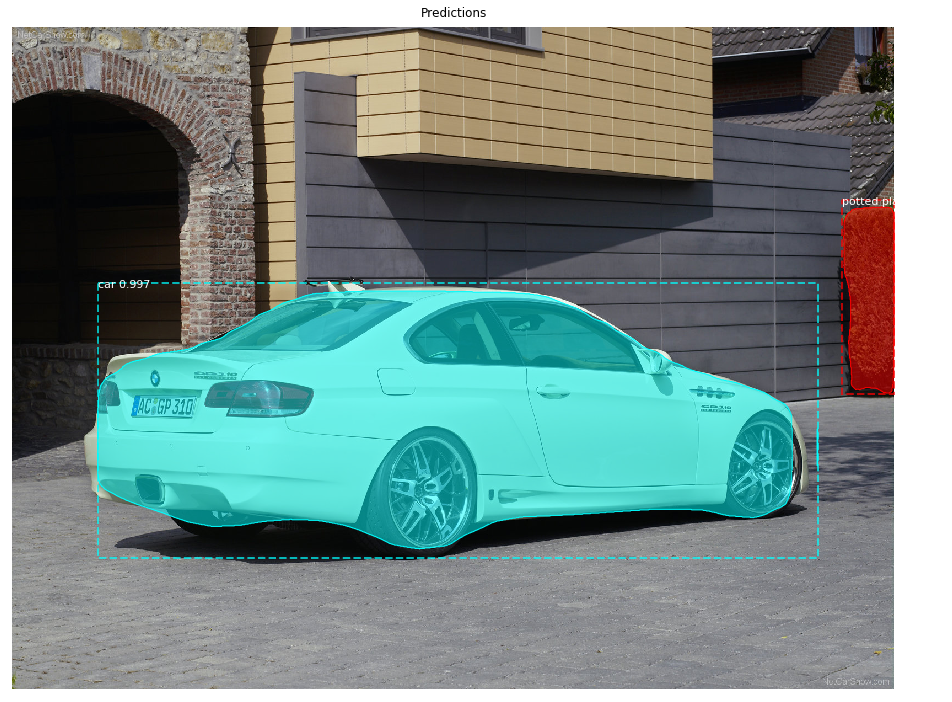

(1200, 1600, 3) float64
(1200, 1600, 3) uint8


In [21]:
# pre_mask = mask rcnn으로 segment된 영역의 마스크 (이진처리 하기 전)

num=1
for img in images:
    image=pilimg.open(img)
    image=np.array(image)
    print('image.dtype:', image.dtype)
    results = model.detect([image], verbose=1)
    # cv2.imshow('image', image)
    # Display results
    r = results[0]
    
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                        dataset.class_names, r['scores'],
                        title="Predictions")
    
    #print(r['masks'].shape) # (1200, 1600, 2)
    pre_mask=np.transpose(r['masks'],[2,0,1])
    #print(pre_mask.shape) # (2, 1200, 1600)
    
    for i in range(len(r['class_ids'])):
        if gerne == dataset.class_names[r['class_ids'][i]]:
            roi_area = r['rois'][i]
            
            r_w = roi_area[3] - roi_area[1]
            r_h = roi_area[2] - roi_area[0]
            
            if r_w * r_h < 5000:
                pass
            elif r['scores'][i] < 0.9:
                pass
            else:
                color = comic_color(image)
                rv = background_mask(image, pre_mask[i])
                color = paint_only_background(color, rv)
                # color = bgr2rgb(color)
                # 너무 복잡함..
                
                rv_background_mask = background_mask(image, pre_mask[i])
                #cv2.imwrite("background_binary{}.jpg".format(num), rv_background_mask)
                # cv2.imshow('rv_background_mask', rv_background_mask)
                only_background_img = paint_only_background(image, rv_background_mask)
                only_background_img = bgr2rgb(only_background_img)
                #cv2.imwrite(os.path.join("only_background{}.jpg").format(num), only_background_img)
                # cv2.imshow('only_background_img', only_background_img)
                canny_image = make_canny_image(only_background_img, rv_background_mask, num)
                #cv2.imwrite(os.path.join("canny_edge{}.jpg").format(num), canny_image)
                # cv2.imshow('canny_image', canny_image)
                # colored_background = ()
                print(color.shape, color.dtype)
                color = color.astype('uint8') * 255
                print(canny_image.shape, canny_image.dtype)
                cartoon = cv2.bitwise_and(color, canny_image)

                merged_image = image_merge(cartoon, canny_image)
                # imread, imwrite 에서 한글(유니코드)로 인한 문제 https://jangjy.tistory.com/337 
                # cv2.imwrite(os.path.join(target_directory, "{}.jpg".format(num)), merged_image)
                # cv2.imwrite(target_directory + "{}.jpg".format(num), merged_image)
                
                imwrite(target_directory + "{}.jpg".format(num), merged_image)
                num += 1

In [17]:
print(rv_background_mask)

[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
